## Install and Import

In [ ]:
%pip install -q rdkit pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import tensorflow as tf
from tensorflow import keras

RDLogger.DisableLog("rdApp.*")

In [ ]:
%pip install -q pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 47.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.3.2 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [ ]:
import pennylane as qml
from pennylane import numpy as np

## Dataset

In [ ]:
class DataHelper():
    def __init__(self):
        csv_path = tf.keras.utils.get_file("qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")
        self.data = list()
        with open(csv_path, "r")  as fin:
            for line in fin.readlines()[1:]:
                self.data.append(line.split(",")[1])

    def __getitem__(self, idx: int):
        smiles = self.data[idx]
        print(f"SMILES: {smiles}")
        mol = Chem.MolFromSmiles(smiles)
        print(f"Number of Heavy Atoms: {mol.GetNumHeavyAtoms()}")
        return mol

In [ ]:
DH = DataHelper()

29856825/29856825 [==============================] - 1s 0us/step


## Utilities

In [ ]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

In [ ]:
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

In [ ]:
NUM_ATOMS = 9  # Maximum number of atoms
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space

In [ ]:
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)
    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")
    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1
    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1
    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1
    return adjacency, features

In [ ]:
def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]
    for atom_type_idx in np.argmax(features, axis=1):
        try: atom = Chem.Atom(atom_mapping[atom_type_idx])
        except KeyError:
            atom_type_idx = atom_type_idx.numpy()
            atom = Chem.Atom(atom_mapping[atom_type_idx])
            #raise RuntimeError("Cannot use Tensor as list index")
        _ = molecule.AddAtom(atom)
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE: return None
    return molecule

## Generate Training Set

In [ ]:
adjacency_tensor, feature_tensor = [], []
for smiles in DH.data[::250]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (536, 5, 9, 9)
feature_tensor.shape = (536, 9, 5)


## Graph Discriminator

### Relational Graph Convolution Layer

In [ ]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

### Actual Disciminator
It will be Classical for now

In [ ]:
def GraphDiscriminator(gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)
    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)([adjacency, features_transformed])
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)
    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    # For each molecule, output a single scalar value expressing the
    # "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)
    return keras.Model(inputs=[adjacency, features], outputs=x_out)

In [ ]:
discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

In [ ]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 9, 9)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9, 5)]       0           []                               
                                                                                                  
 relational_graph_conv_layer (R  (None, 9, 128)      3200        ['input_1[0][0]',                
 elationalGraphConvLayer)                                         'input_2[0][0]']                
                                                                                                  
 relational_graph_conv_layer_1   (None, 9, 128)      81920       ['input_1[0][0]',            

## Quantum Generator

#### Quantum Dense Layer

In [ ]:
def QuantumDenseLayer(WIRES, backend="default.qubit.tf"):
    device = qml.device(backend, WIRES)
    weight_shapes = {"weights": (1, WIRES, 3)}

    def QDLCircuit(inputs, weights):
        qml.templates.AmplitudeEmbedding(inputs[0], wires=range(WIRES), normalize=True)
        qml.templates.StronglyEntanglingLayers(weights, wires=range(WIRES))
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(WIRES)]

    QDL = qml.QNode(QDLCircuit, device, interface="tf")
    return qml.qnn.KerasLayer(QDL, weight_shapes=weight_shapes, output_dim = [WIRES,])

#### Actual Graph Generator

In [ ]:
def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape, batch_size=16,):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    # Propagate through one or more densely connected layers
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

        qubits = int(np.log2(units))
        QDL = QuantumDenseLayer(qubits)
        x = QDL(x)

    #x = [QDL(x[i]) for i in range(batch_size)]
    #x = tf.convert_to_tensor(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)
    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)
    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")

In [ ]:
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

In [ ]:
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          8320        ['input_3[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_3[0][0]']                
                                                                                                  
 keras_layer (KerasLayer)       (None, 7)            21          ['dropout_2[0][0]']              
                                                                                          

## Compile Final Model

#### Hide Big Block of Code

In [ ]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        # Train the discriminator for one or more steps
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Train the generator for one or more steps
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

#### Show Remaining Code

In [ ]:
QWGAN = GraphWGAN(generator, discriminator)

In [ ]:
QWGAN.compile(optimizer_generator=keras.optimizers.Adam(5e-4), optimizer_discriminator=keras.optimizers.Adam(5e-4),)

## Train this MF
TPUs are magical

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
QWGAN.fit([adjacency_tensor, feature_tensor], epochs=5, batch_size=1)

Epoch 1/5
536/536 [==============================] - 1039s 2s/step - loss_gen: 4.9619 - loss_dis: -6.2859
Epoch 2/5
536/536 [==============================] - 1001s 2s/step - loss_gen: 2.5246 - loss_dis: -3.3199
Epoch 3/5
536/536 [==============================] - 982s 2s/step - loss_gen: 3.4771 - loss_dis: -2.0685
Epoch 4/5
536/536 [==============================] - 922s 2s/step - loss_gen: 3.6819 - loss_dis: -1.4103
Epoch 5/5
536/536 [==============================] - 956s 2s/step - loss_gen: 3.9990 - loss_dis: -3.2827


### Sample Molecules

In [ ]:
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    return [graph_to_molecule([adjacency[i].numpy(), features[i].numpy()]) for i in range(batch_size)]

In [ ]:
num_sample = 1

In [ ]:
molecules = []
for i in range(num_sample):
    molecule = sample(QWGAN.generator, batch_size=1)[0]
    molecules.append(molecule)

1/1 [==============================] - 1s 1s/step


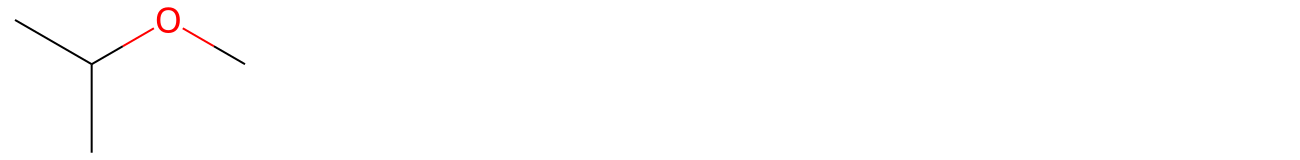

In [ ]:
MolsToGridImage([m for m in molecules if m is not None], molsPerRow=5, subImgSize=(260, 160))

In [ ]:
xsample = molecules[0]

In [ ]:
xsample.GetNumHeavyAtoms()

5

### Check if Valid (Rule of 5)

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors
from rdkit.Chem.Crippen import MolLogP

In [ ]:
def valid_molecule(illicit_drug):
    return all([
        NumHAcceptors(illicit_drug) <= 10,
        NumHDonors(illicit_drug) <= 5,
        ExactMolWt(illicit_drug) <= 500,
        MolLogP(illicit_drug) <= 5
    ])

In [ ]:
valid_molecule(xsample)

True

In [ ]:
AllChem.Compute2DCoords(xsample)
xsample.GetConformer(0)

In [ ]:
for i, atom in enumerate(xsample.GetAtoms()):
    positions = xsample.GetConformer(0).GetAtomPosition(i)
    print(f"{atom.GetSymbol()}, {positions.x}, {positions.y}, {positions.z}")

O, 0.7794228634059948, 0.75, 0.0
C, -1.818653347947321, 0.7500000000000004, 0.0
C, -0.5196152422706634, 1.1102230246251565e-16, 0.0
C, -0.5196152422706639, -1.5000000000000002, 0.0
C, 2.078460969082653, -2.220446049250313e-16, 0.0


### Rush Geometry

In [ ]:
%pip -q install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 MB 3.8 MB/s eta 0:00:00


In [ ]:
from pyscf import scf, gto, geomopt

In [ ]:
atom = []
for i, symb in enumerate(xsample.GetAtoms()):
    positions = xsample.GetConformer(0).GetAtomPosition(i)
    atom.append([symb.GetSymbol(), (positions.x, positions.y, positions.z)])

In [ ]:
atom

[['O', (0.7794228634059948, 0.75, 0.0)],
 ['C', (-1.818653347947321, 0.7500000000000004, 0.0)],
 ['C', (-0.5196152422706634, 1.1102230246251565e-16, 0.0)],
 ['C', (-0.5196152422706639, -1.5000000000000002, 0.0)],
 ['C', (2.078460969082653, -2.220446049250313e-16, 0.0)]]

In [ ]:
mol = gto.Mole()
mol.atom = atom
mol.build()

In [ ]:
mf = scf.RHF(mol).newton()
mf.kernel()

converged SCF energy = -222.766128152893


-222.76612815289286

In [ ]:
print(f"Dipole moment of the molecule, {mf.dip_moment()}")

Dipole moment(X, Y, Z, Debye):  1.00096, -0.16022,  0.00000
Dipole moment of the molecule, [ 1.00095616e+00 -1.60220095e-01  4.62102124e-09]


In [ ]:
print(f"Total Energy: {mf.e_tot}\n\nOrbital Energies: {mf.mo_energy}\n\n Orbital Occupancy: {mf.mo_occ}\n\n Orbitcal coefficients: {mf.mo_coeff}")

Total Energy: -222.76612815289286

Orbital Energies: [-20.3464597  -11.06547604 -11.04404757 -11.02064048 -11.00168757
  -1.30437524  -0.94754937  -0.7601305   -0.71573199  -0.53532131
  -0.4833333   -0.42913703  -0.41010304  -0.33771872  -0.27895563
  -0.12784121   0.09613539   0.16312028   0.16694365   0.20841381
   0.36537314   0.46214785   0.59266725   0.75741271   0.80706101]

 Orbital Occupancy: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]

 Orbitcal coefficients: [[ 9.94408255e-01 -4.24142644e-04  1.37573592e-05 -1.27173793e-06
  -4.76579701e-04 -2.31113146e-01 -4.30117564e-02 -4.16263535e-02
   4.69778844e-02 -7.15214077e-02 -8.36864952e-11  9.64523802e-03
   4.60574787e-03  1.85057695e-02 -4.05081777e-11  4.62602720e-02
   1.11410300e-02 -1.09002436e-09  2.26492369e-03  1.96974312e-11
   3.73935760e-11 -1.07699433e-01 -2.26832045e-03  2.61427893e-02
  -5.92326723e-03]
 [ 2.41914484e-02  3.93360419e-03 -1.83217188e-04  1.18082635e-04
   4.034094